In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [42]:
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('/content/drive/MyDrive/Thesis/MalMem/Classification/balanced.csv')
lab=LabelEncoder()
data['Class']=lab.fit_transform(data['Class'])
data['Category']=lab.fit_transform(data['Category'])
#data['Family']=lab.fit_transform(data['Family'])
#data = data.drop(['Class'], axis=1)
#data = data.drop(['Category'], axis=1)
data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [43]:
data = data.drop_duplicates()

In [44]:
import pandas as pd
from scipy import stats

# Define a threshold for z-score, typically 2 or 3
z_score_threshold = 3

# Function to remove outliers based on z-score for all columns
def remove_outliers_zscore_all_columns(data, threshold):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outliers = (abs_z_scores > threshold).all(axis=1)
    df_no_outliers = data[~outliers]
    return df_no_outliers

# Apply z-score outlier removal for all columns
df_no_outliers = remove_outliers_zscore_all_columns(data, z_score_threshold)
data = df_no_outliers

In [12]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Output hidden; open in https://colab.research.google.com to view.

In [45]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# Assuming your dataset is stored in a pandas DataFrame called 'df'

# Identify skewed features
skewness = data.apply(lambda x: skew(x))
skew_features = skewness[abs(skewness) > 0.5].index

# Apply log transformation to skewed features
#data[skew_features] = np.log1p(data[skew_features])

# Alternatively, you can use PowerTransformer for a more general approach
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data[skew_features] = scaler.fit_transform(data[skew_features].values)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


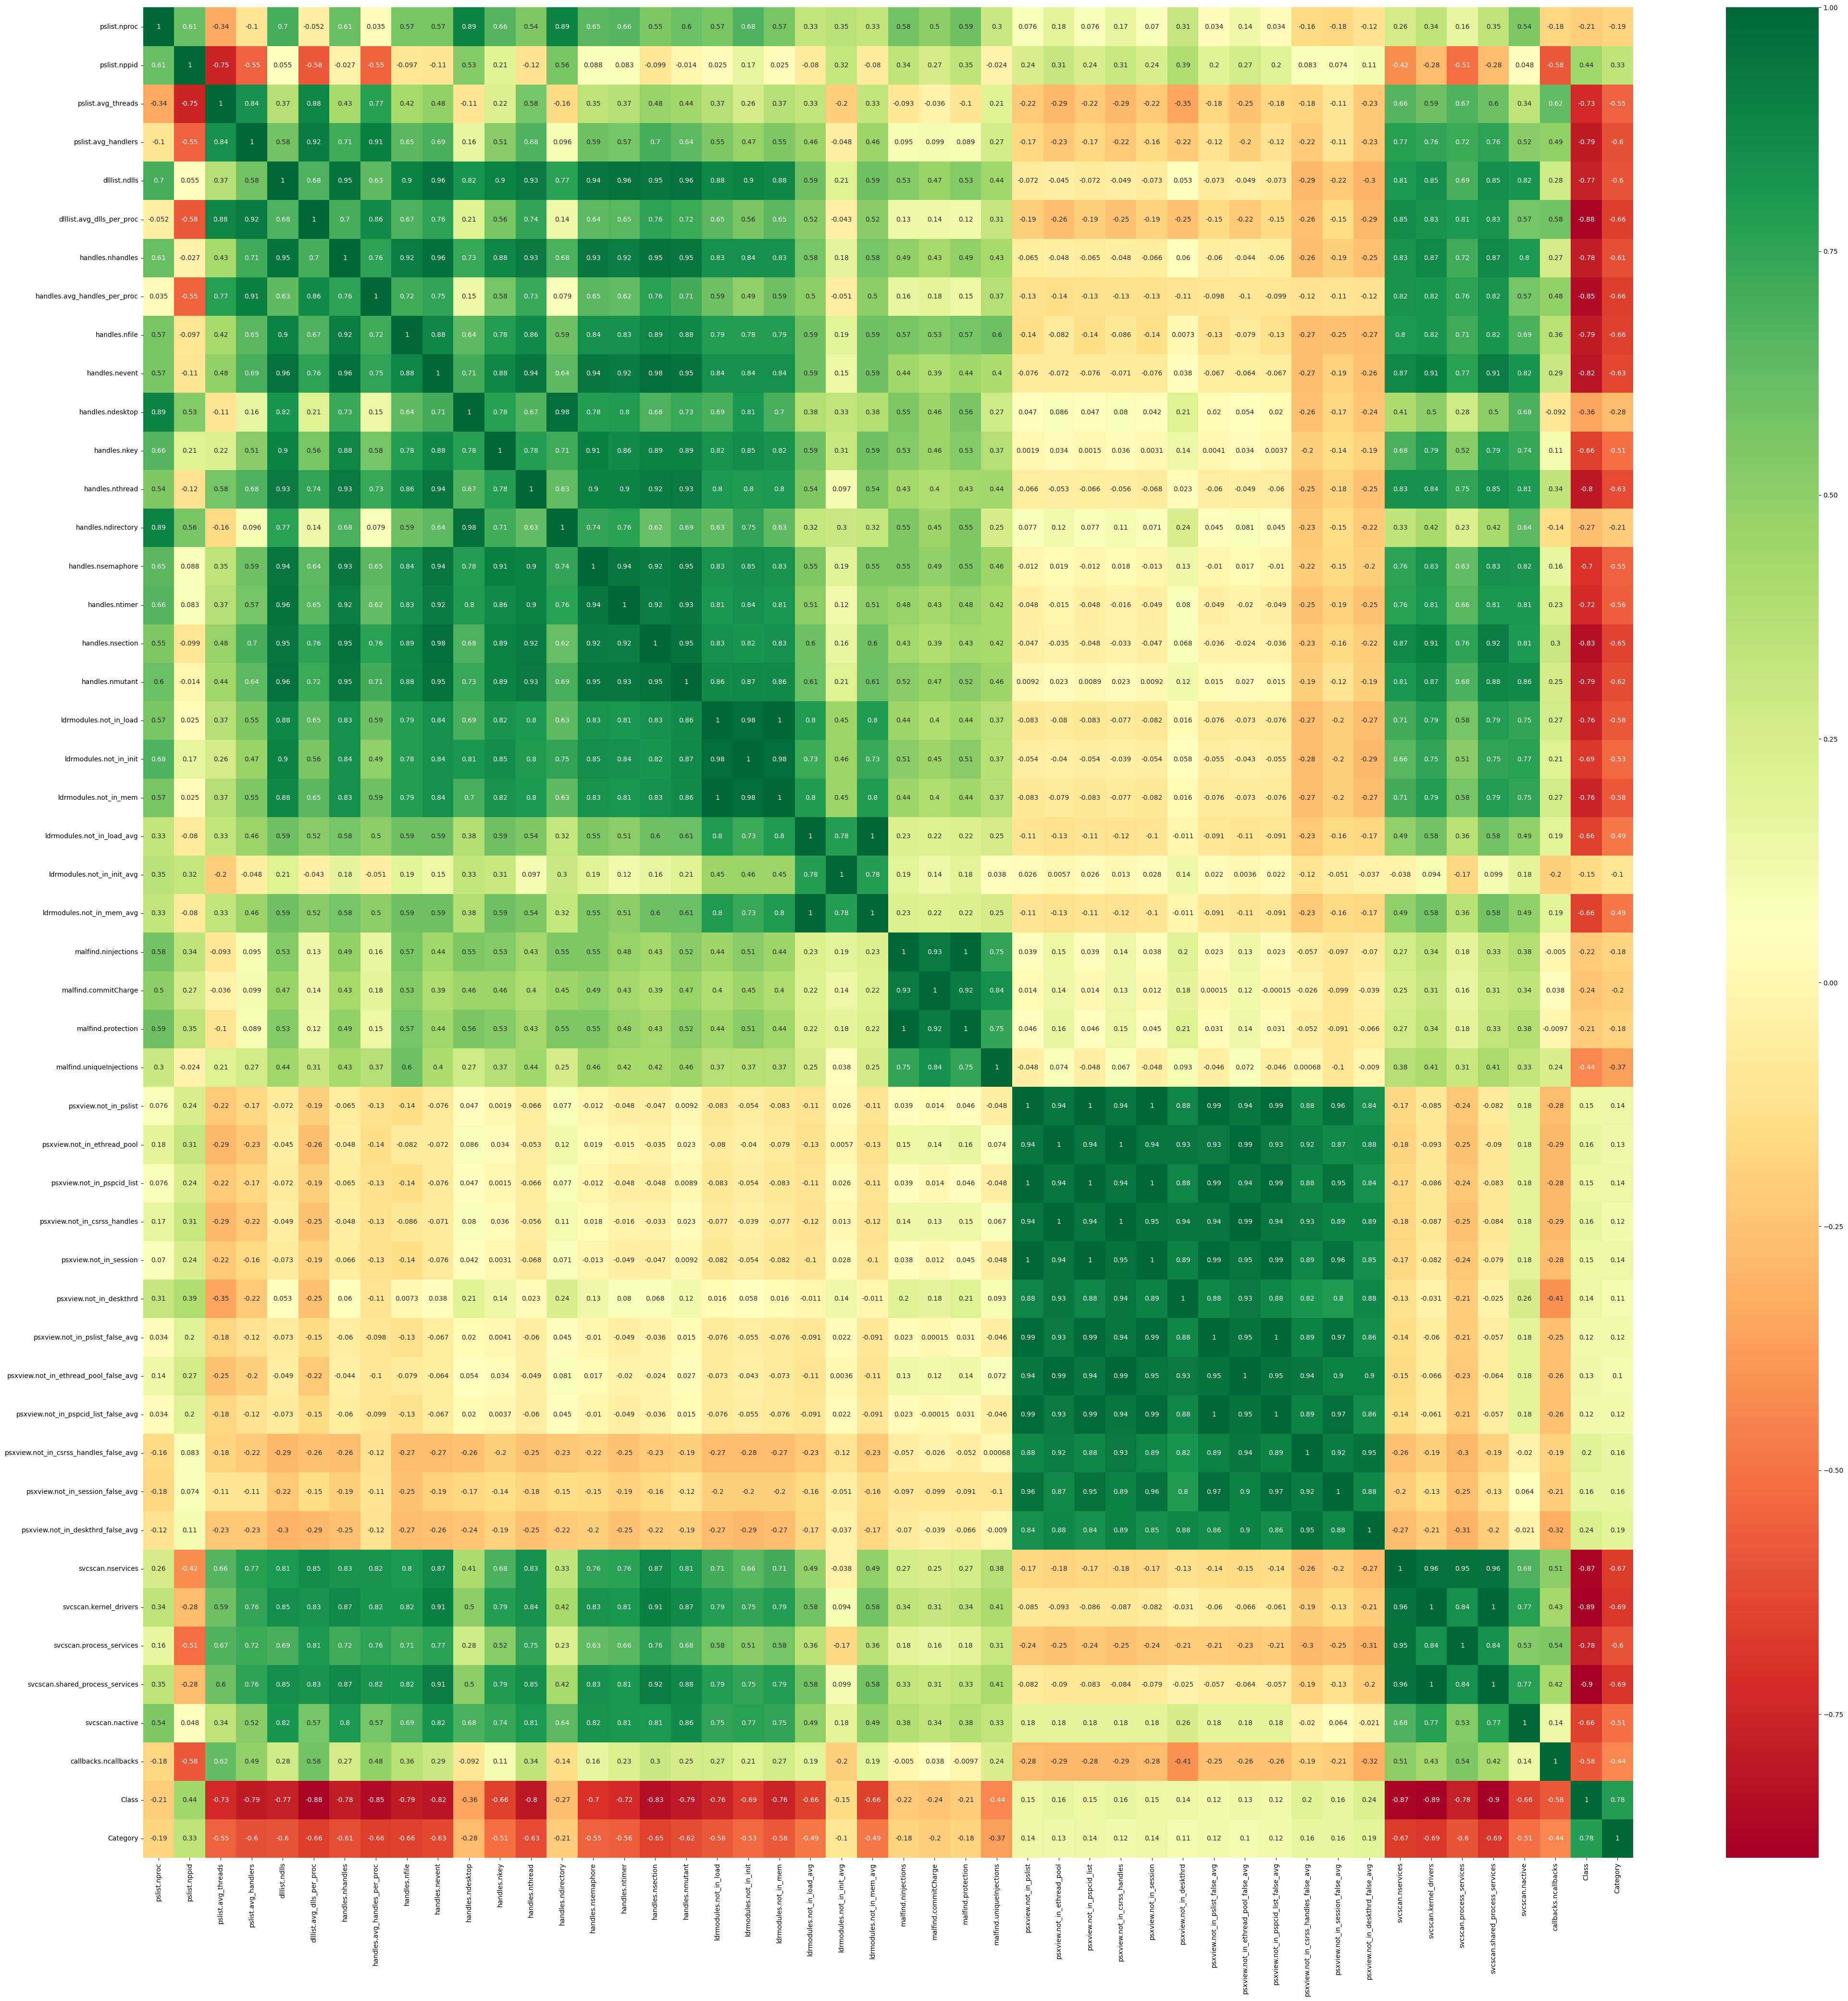

In [14]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

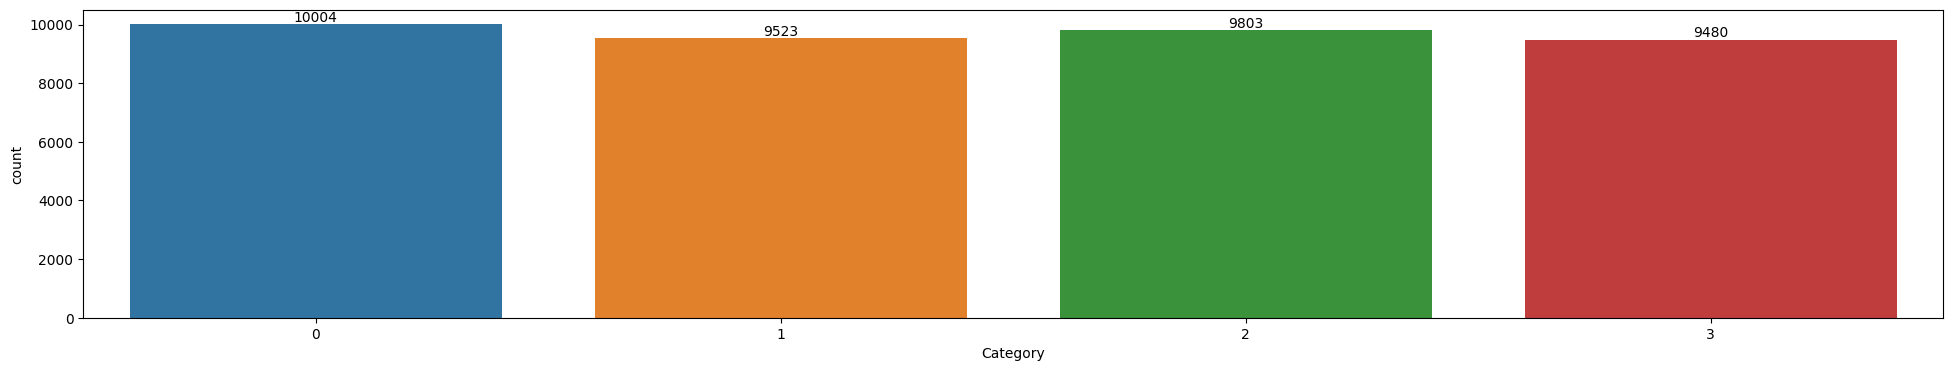

In [22]:
plt.figure(figsize=(24,4))
ax = sns.countplot(x='Category',data=data)
for i in ax.containers:
    ax.bar_label(i,)

<h3>Normalization</h3>

In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [47]:
# Separate features and labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Class labels
X.shape

(38810, 47)

In [48]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(40016, 47)

Fold 5/5: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


Mean Accuracy: 68.53%
Mean Training Time (seconds): 3.45
Mean Testing Time (seconds): 0.40
Mean Training Loss: 0.6820
Mean Test Loss: 0.6927


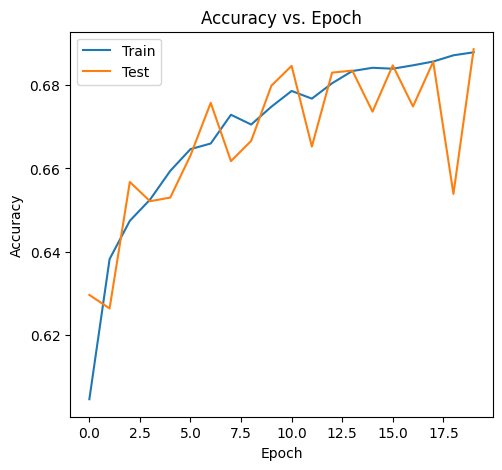

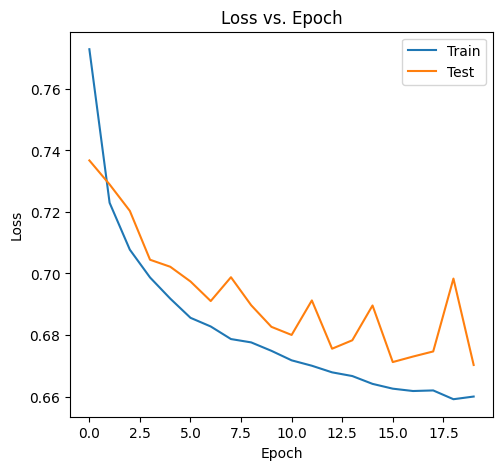

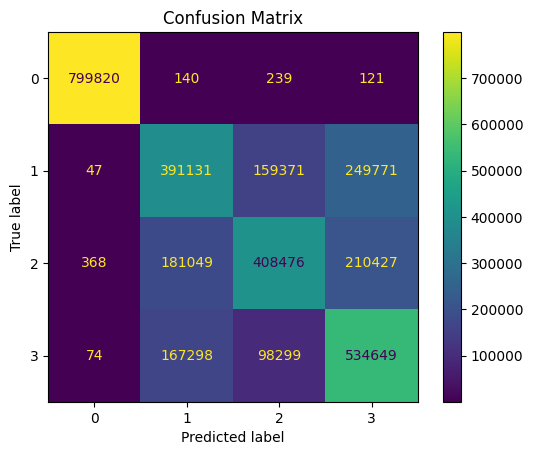

In [49]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/20_ep_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification//graphs/cnn/20_ep_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/20_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 30 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 30/30 [02:04<00:00,  4.15s/it]


Mean Accuracy: 68.72%
Mean Training Time (seconds): 4.30
Mean Testing Time (seconds): 0.46
Mean Training Loss: 0.6725
Mean Test Loss: 0.6912


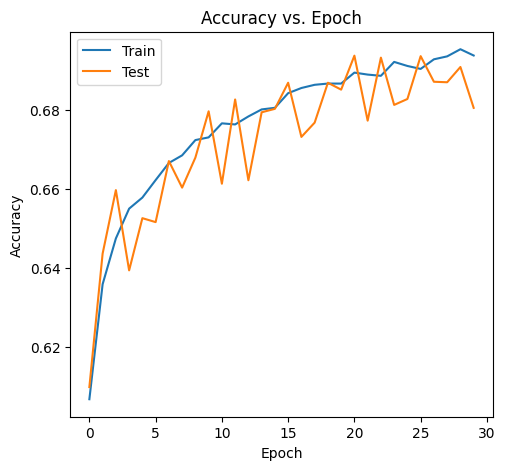

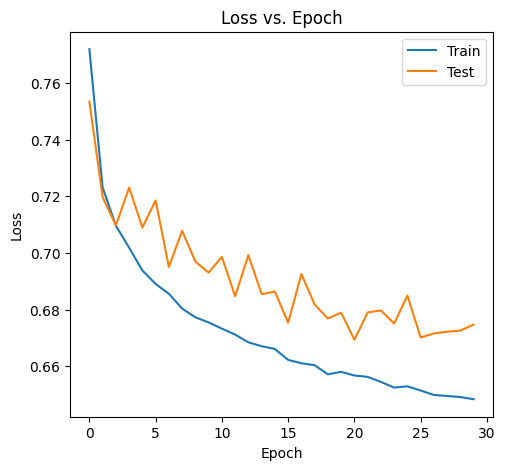

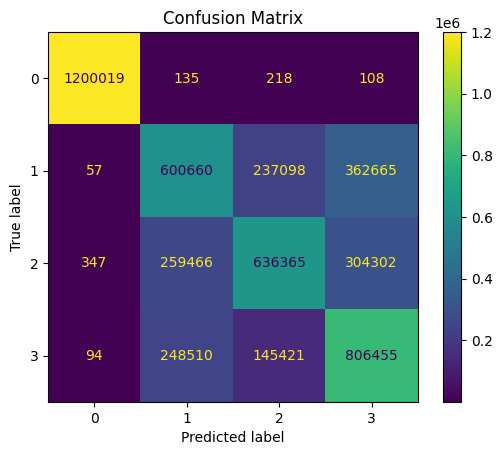

In [50]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/30_ep_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification//graphs/cnn/30_ep_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/30_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 50 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


Mean Accuracy: 69.01%
Mean Training Time (seconds): 3.76
Mean Testing Time (seconds): 0.42
Mean Training Loss: 0.6587
Mean Test Loss: 0.6739


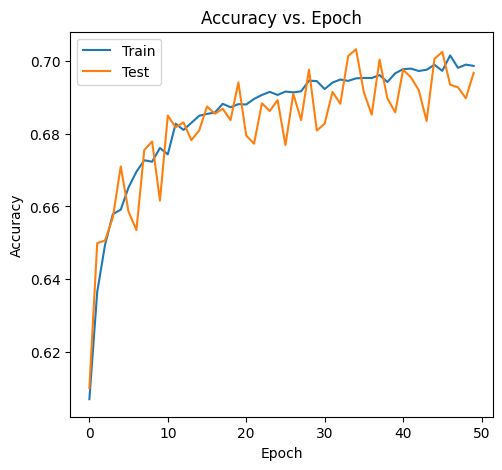

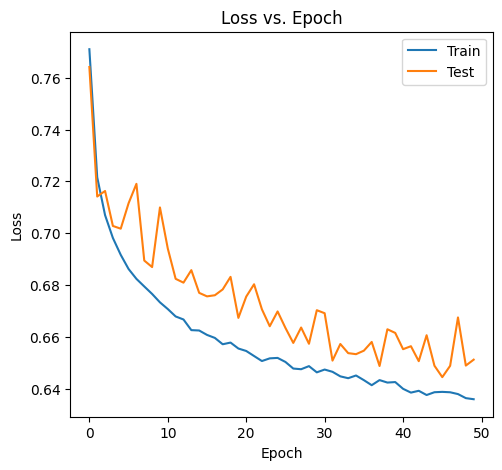

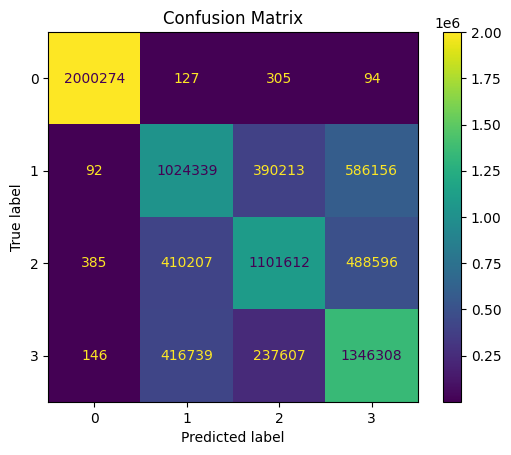

In [51]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 50
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/50_ep_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification//graphs/cnn/50_ep_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/50_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 100 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


Mean Accuracy: 70.81%
Mean Training Time (seconds): 3.67
Mean Testing Time (seconds): 0.41
Mean Training Loss: 0.6466
Mean Test Loss: 0.6656


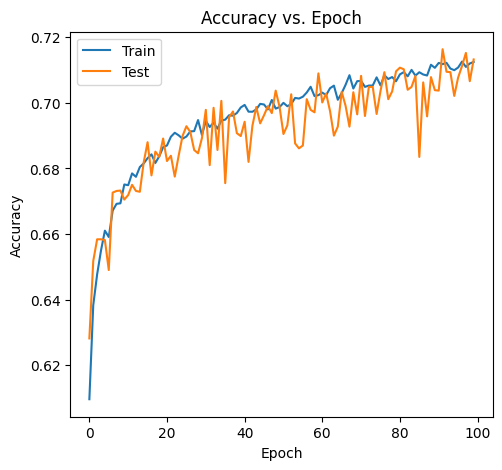

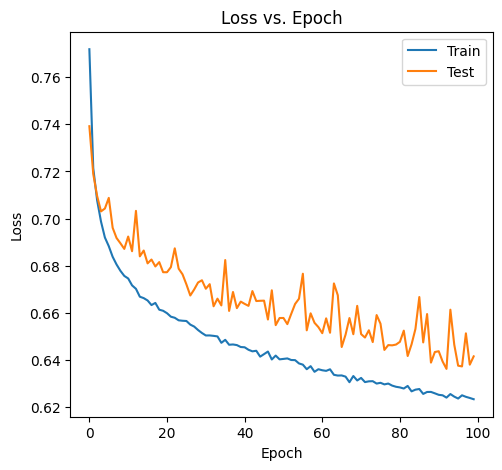

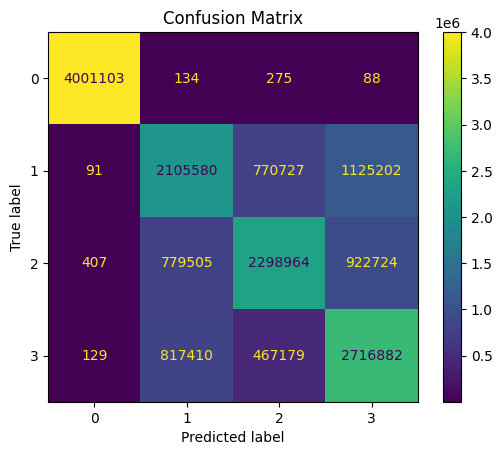

In [52]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/100_ep_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification//graphs/cnn/100_ep_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/100_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 150 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 150/150 [09:01<00:00,  3.61s/it]


Mean Accuracy: 70.95%
Mean Training Time (seconds): 3.79
Mean Testing Time (seconds): 0.42
Mean Training Loss: 0.6412
Mean Test Loss: 0.6589


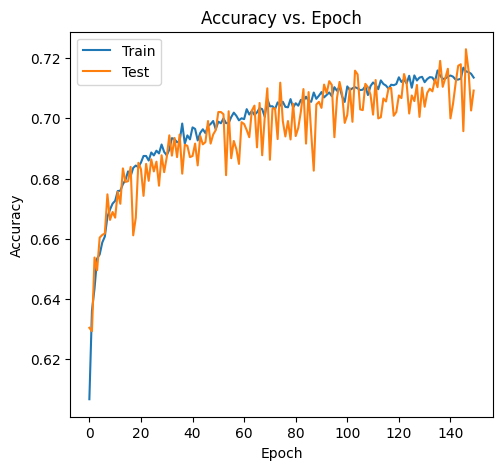

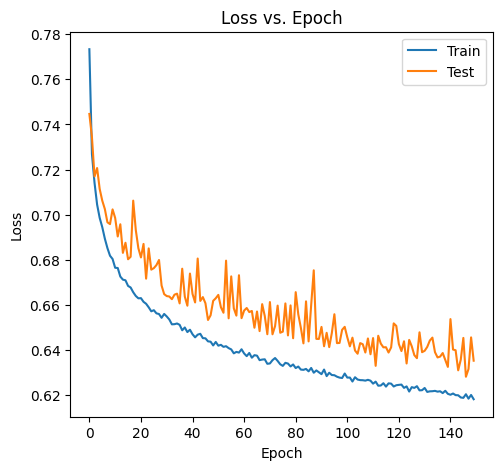

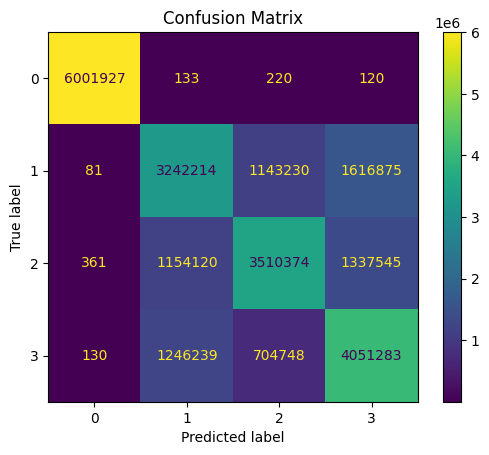

In [53]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 150
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/150_ep_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification//graphs/cnn/150_ep_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/cnn/150_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()